Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5091 - loss: 0.6922 - val_accuracy: 0.2077 - val_loss: 0.7054
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4991 - loss: 0.6848 - val_accuracy: 0.2081 - val_loss: 0.7153
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4988 - loss: 0.6782 - val_accuracy: 0.2152 - val_loss: 0.7187
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5087 - loss: 0.6700 - val_accuracy: 0.2608 - val_loss: 0.7194
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5487 - loss: 0.6602 - val_accuracy: 0.3639 - val_loss: 0.7122
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6114 - loss: 0.6507 - val_accuracy: 0.4606 - val_loss: 0.7015
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6689 - loss: 0.6385 - val_accuracy: 0.5375 - val_loss: 0.6872
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7115 - loss: 0.6250 - val_accuracy: 0.5945 - val_l

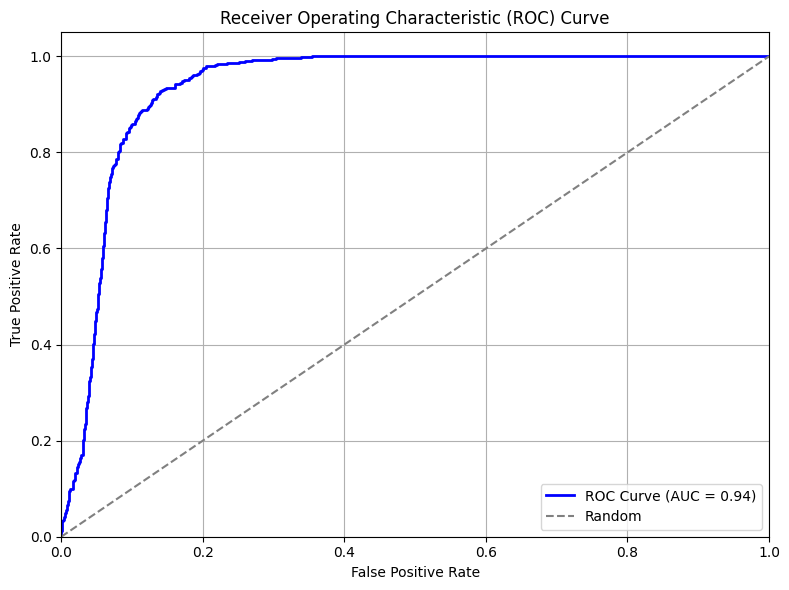

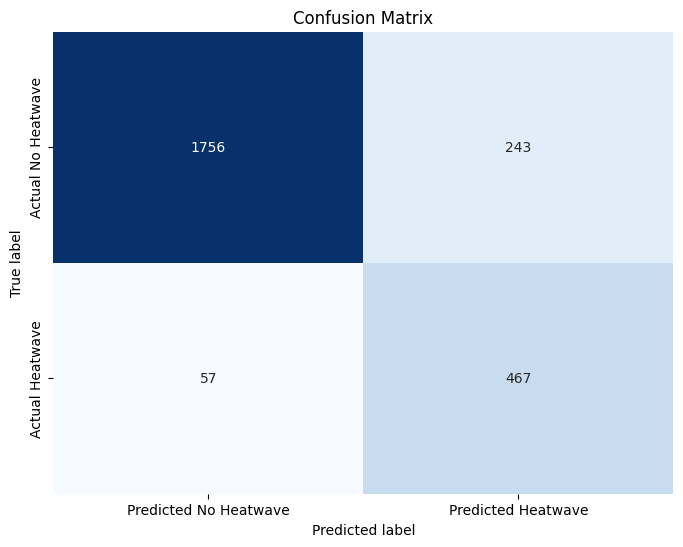

NameError: name 'precision_score' is not defined

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Predict heatwave for training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# Predict heatwave for testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Combine predictions with original data using indices
train_predictions = pd.DataFrame({
    'time': df.loc[train_indices, 'time'].values,
    'tavg': df.loc[train_indices, 'tavg'].values,
    'tmin': df.loc[train_indices, 'tmin'].values,
    'tmax': df.loc[train_indices, 'tmax'].values,
    'humid': df.loc[train_indices, 'humid'].values,
    'True_Heatwave': y_train,
    'Predicted_Heatwave': y_train_pred[:, 0]
})

test_predictions = pd.DataFrame({
    'time': df.loc[test_indices, 'time'].values,
    'tavg': df.loc[test_indices, 'tavg'].values,
    'tmin': df.loc[test_indices, 'tmin'].values,
    'tmax': df.loc[test_indices, 'tmax'].values,
    'humid': df.loc[test_indices, 'humid'].values,
    'True_Heatwave': y_test,
    'Predicted_Heatwave': y_test_pred[:, 0]
})

# Save predictions to CSV
train_predictions.to_csv('train_predictions.csv', index=False)
test_predictions.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'train_predictions.csv' and 'test_predictions.csv'")

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(date_str, avg_tavg, avg_tmin, avg_tmax, avg_humid, threshold=0.5):
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."
    
    sample = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
    sample_scaled = scaler.transform(sample)
    sample_scaled = sample_scaled.reshape((1, 1, sample_scaled.shape[1]))
    prediction_prob = model.predict(sample_scaled)
    prediction = (prediction_prob > threshold).astype(int)
    return "Heatwave" if prediction == 1 else "No Heatwave"

# Continuous prediction loop
while True:
    # Prompt user for a date input
    date_to_predict = input("Enter a date to predict (YYYY-MM-DD), or 'exit' to quit: ")
    
    # Check if user wants to exit
    if date_to_predict.lower() == 'exit':
        print("Exiting prediction loop.")
        break
    
    # Find the actual data for the specified date
    actual_data = df[df['time'] == date_to_predict]
    
    if not actual_data.empty:
        avg_tavg = actual_data['tavg'].values[0]
        avg_tmin = actual_data['tmin'].values[0]
        avg_tmax = actual_data['tmax'].values[0]
        avg_humid = actual_data['humid'].values[0]

        # Predict heatwave for the specified date
        prediction = predict_heatwave(date_to_predict, avg_tavg, avg_tmin, avg_tmax, avg_humid, threshold=0.5)
        print(f'Prediction for {date_to_predict}: {prediction}  Actual: {actual_data["Heatwave"].values[0]}')
    else:
        # Use historical averages for prediction if no actual data is available
        avg_tavg = df['tavg'].mean()
        avg_tmin = df['tmin'].mean()
        avg_tmax = df['tmax'].mean()
        avg_humid = df['humid'].mean()

        prediction = predict_heatwave(date_to_predict, avg_tavg, avg_tmin, avg_tmax, avg_humid, threshold=0.5)
        print(f'Prediction for {date_to_predict}: {prediction} (using historical averages)')

# Plot ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4274 - loss: 0.6965 - val_accuracy: 0.2077 - val_loss: 0.7086
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5004 - loss: 0.6892 - val_accuracy: 0.2077 - val_loss: 0.7177
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4997 - loss: 0.6830 - val_accuracy: 0.2089 - val_loss: 0.7219
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5108 - loss: 0.6746 - val_accuracy: 0.2212 - val_loss: 0.7239
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5186 - loss: 0.6675 - val_accuracy: 0.2941 - val_loss: 0.7205
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5692 - loss: 0.6580 - val_accuracy: 0.3967 - val_loss: 0.7122
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6259 - loss: 0.6484 - val_accuracy: 0.4839 - val_loss: 0.7000
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6740 - loss: 0.6333 - val_accuracy: 0.5517 - val_l

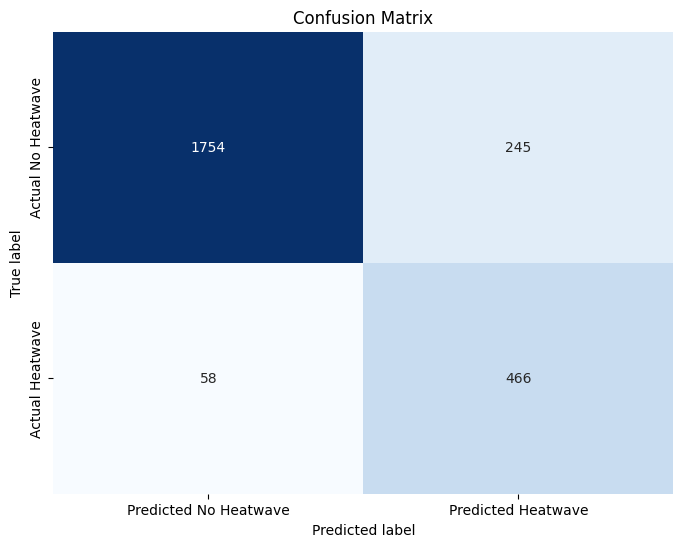

Accuracy: 0.88
Precision: 0.66
Recall: 0.89
F1-score: 0.75


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Predict heatwave for training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# Predict heatwave for testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Print accuracy, precision, recall, and F1-score
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5001 - loss: 0.6882 - val_accuracy: 0.2081 - val_loss: 0.7214
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4993 - loss: 0.6816 - val_accuracy: 0.2105 - val_loss: 0.7268
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5022 - loss: 0.6754 - val_accuracy: 0.2323 - val_loss: 0.7288
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5254 - loss: 0.6675 - val_accuracy: 0.3020 - val_loss: 0.7257
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5730 - loss: 0.6592 - val_accuracy: 0.4019 - val_loss: 0.7152
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6260 - loss: 0.6505 - val_accuracy: 0.4903 - val_loss: 0.7019
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6745 - loss: 0.6386 - val_accuracy: 0.5379 - val_loss: 0.6892
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7111 - loss: 0.6212 - val_accuracy: 0.5937 - val_l

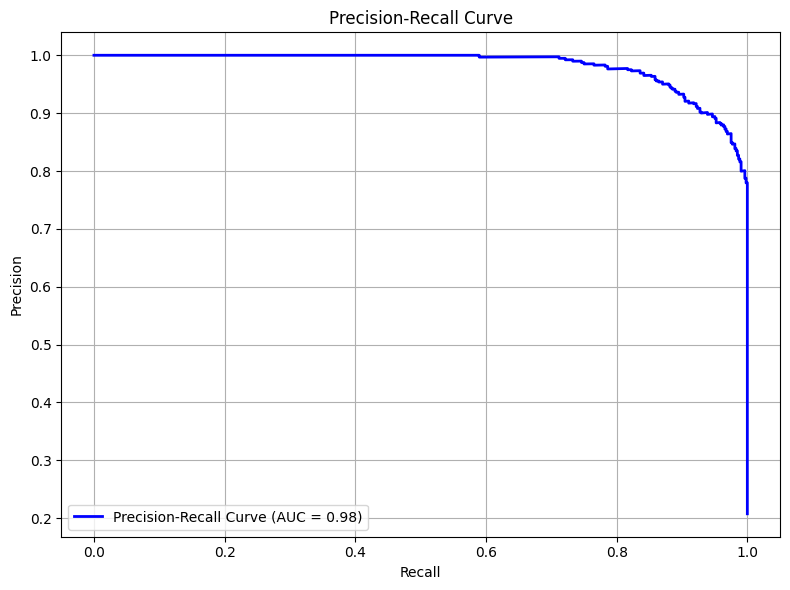

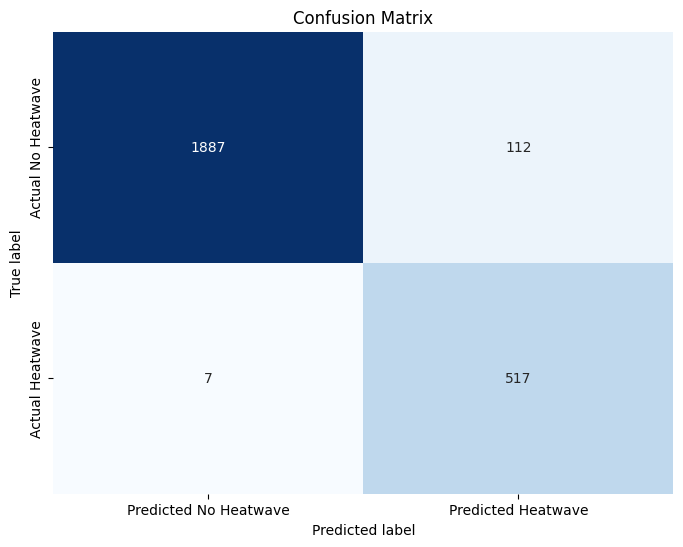

Accuracy: 0.95
Precision: 0.82
Recall: 0.99
F1-score: 0.90


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Predict heatwave for training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# Predict heatwave for testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Compute precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5099 - loss: 0.6903 - val_accuracy: 0.2077 - val_loss: 0.7112
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5047 - loss: 0.6837 - val_accuracy: 0.2093 - val_loss: 0.7195
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5014 - loss: 0.6779 - val_accuracy: 0.2235 - val_loss: 0.7236
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5223 - loss: 0.6695 - val_accuracy: 0.2794 - val_loss: 0.7239
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5549 - loss: 0.6628 - val_accuracy: 0.3750 - val_loss: 0.7183
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6089 - loss: 0.6507 - val_accuracy: 0.4641 - val_loss: 0.7067
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6668 - loss: 0.6378 - val_accuracy: 0.5256 - val_loss: 0.6917
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7147 - loss: 0.6226 - val_accuracy: 0.6036 - val_

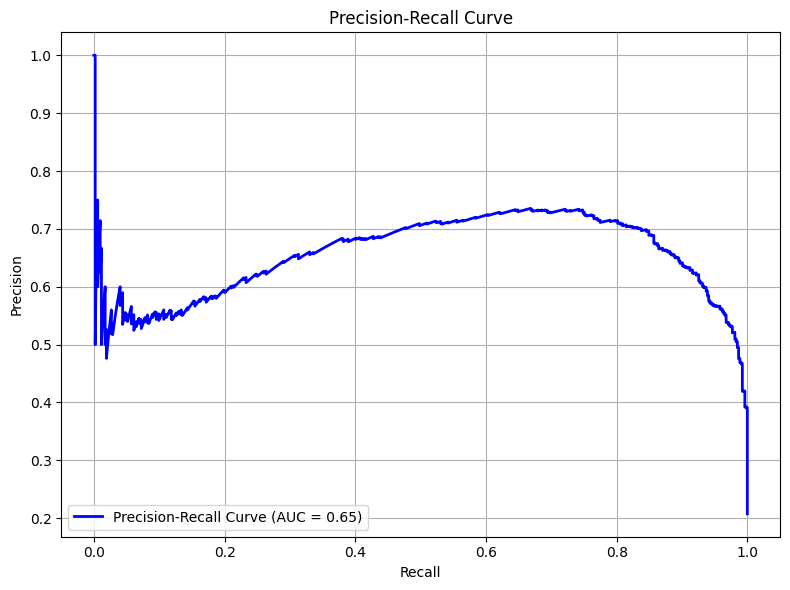

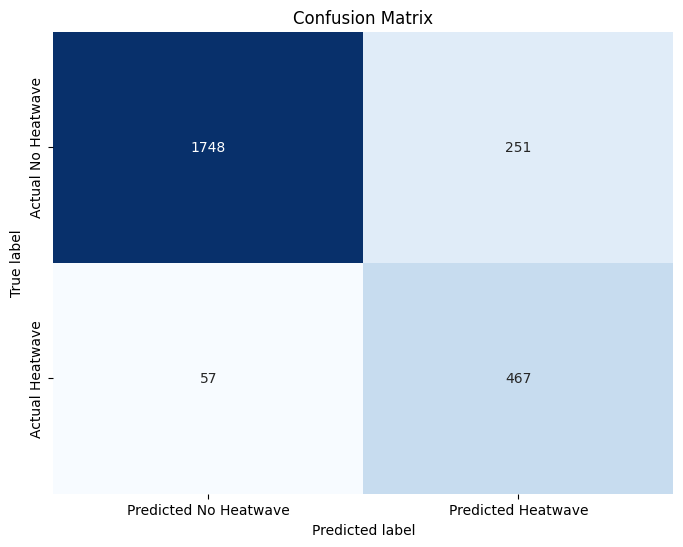

Accuracy: 0.88
Precision: 0.65
Recall: 0.89
F1-score: 0.75


ValueError: time data '2025-05-05' does not match format '%d-%m-%Y'

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Predict heatwave for training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# Predict heatwave for testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Compute precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Ask user for dates
date_str = input("Enter the date in format DD-MM-YYYY: ")
date_to_check = datetime.strptime(date_str, '%d-%m-%Y')

# Find the corresponding row in the dataframe
selected_row = df[df['time'] == date_to_check]

# Print temperature and humidity of that day
if not selected_row.empty:
    print(f"On {date_to_check.date()}:")
    print(f"Temperature (Tavg): {selected_row['tavg'].values[0]}")
    print(f"Minimum Temperature (Tmin): {selected_row['tmin'].values[0]}")
    print(f"Maximum Temperature (Tmax): {selected_row['tmax'].values[0]}")
    print(f"Humidity: {selected_row['humid'].values[0]}")
else:
    print(f"No data found for {date_to_check.date()}.")

# Plot temperature and humidity against year with heatwave markers
plt.figure(figsize=(12, 8))

# Plot temperature
plt.subplot(2, 1, 1)
plt.plot(df['time'], df['tavg'], label='Tavg', marker='o', markersize=5, linestyle='-', color='b')
plt.plot(df['time'], df['tmin'], label='Tmin', marker='o', markersize=5, linestyle='-', color='g')
plt.plot(df['time'], df['tmax'], label='Tmax', marker='o', markersize=5, linestyle='-', color='r')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature Variation Over Time')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add heatwave markers
heatwave_dates = df[df['Heatwave'] == 1]['time']
heatwave_temps = df[df['Heatwave'] == 1]['tmax']
heatwave_humidities = df[df['Heatwave'] == 1]['humid']
plt.scatter(heatwave_dates, heatwave_temps, marker='x', color='r', label='Heatwave Tmax')
plt.scatter(heatwave_dates, heatwave_humidities, marker='x', color='m', label='Heatwave Humidity')

# Plot humidity
plt.subplot(2, 1, 2)
plt.plot(df['time'], df['humid'], label='Humidity', marker='o', markersize=5, linestyle='-', color='c')
plt.xlabel('Year')
plt.ylabel('Humidity')
plt.title('Humidity Variation Over Time')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add heatwave markers
plt.scatter(heatwave_dates, heatwave_temps, marker='x', color='r', label='Heatwave Tmax')
plt.scatter(heatwave_dates, heatwave_humidities, marker='x', color='m', label='Heatwave Humidity')

plt.tight_layout()
plt.show()


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5001 - loss: 0.6922 - val_accuracy: 0.2564 - val_loss: 0.7083
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5233 - loss: 0.6844 - val_accuracy: 0.2394 - val_loss: 0.7165
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5243 - loss: 0.6782 - val_accuracy: 0.2854 - val_loss: 0.7188
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5548 - loss: 0.6722 - val_accuracy: 0.3666 - val_loss: 0.7162
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5965 - loss: 0.6637 - val_accuracy: 0.4372 - val_loss: 0.7117
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6421 - loss: 0.6535 - val_accuracy: 0.4954 - val_loss: 0.7028
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6845 - loss: 0.6407 - val_accuracy: 0.5458 - val_loss: 0.6891
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7238 - loss: 0.6270 - val_accuracy: 0.6017 - val_l

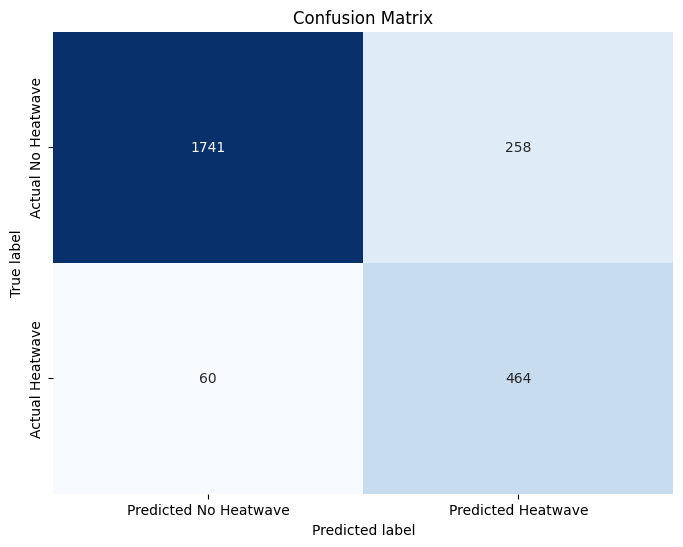

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data (assuming 'hu.csv' is your dataset)
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Predict heatwave for training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# Predict heatwave for testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Print accuracy, precision, recall, and F1-score
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4979 - loss: 0.6876 - val_accuracy: 0.2077 - val_loss: 0.7191
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5003 - loss: 0.6801 - val_accuracy: 0.2097 - val_loss: 0.7270
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4993 - loss: 0.6737 - val_accuracy: 0.2327 - val_loss: 0.7259
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5228 - loss: 0.6650 - val_accuracy: 0.3056 - val_loss: 0.7221
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5719 - loss: 0.6561 - val_accuracy: 0.4086 - val_loss: 0.7123
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6348 - loss: 0.6451 - val_accuracy: 0.4911 - val_loss: 0.6988
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6857 - loss: 0.6315 - val_accuracy: 0.5628 - val_loss: 0.6824
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7259 - loss: 0.6155 - val_accuracy: 0.6318 - val_l

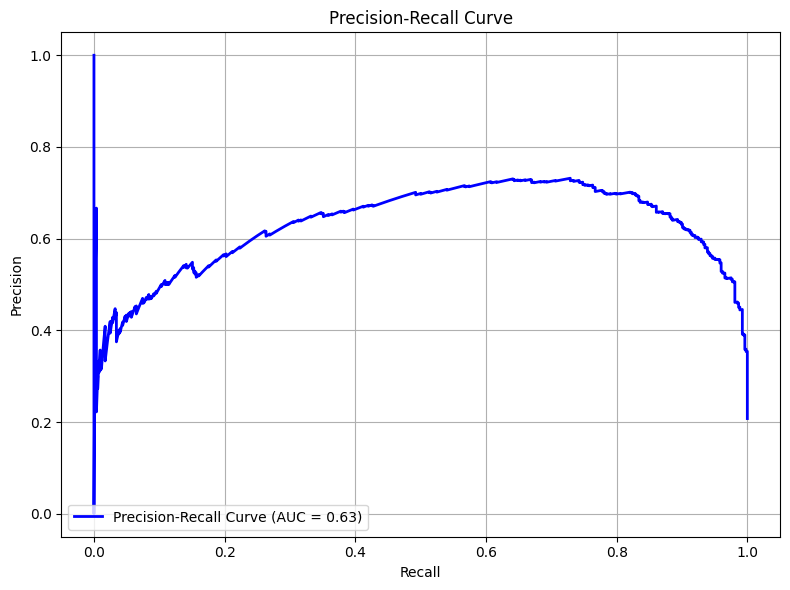

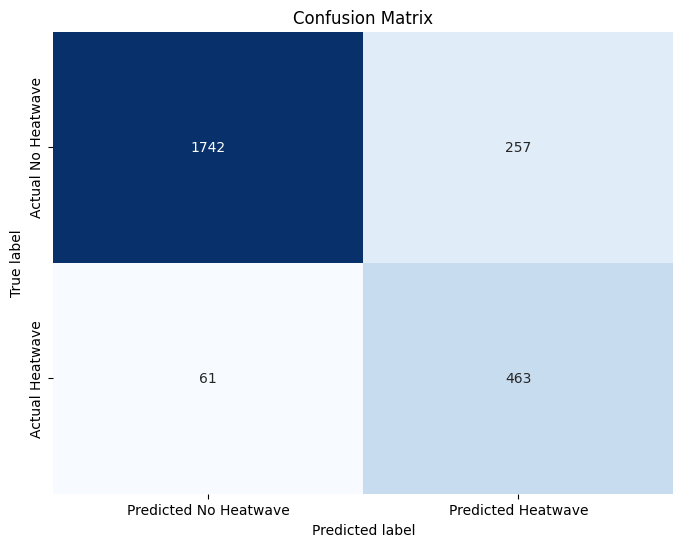

Accuracy: 0.87
Precision: 0.64
Recall: 0.88
F1-score: 0.74


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(date_str, avg_tavg, avg_tmin, avg_tmax, avg_humid, threshold=0.5):
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."
    
    sample = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
    sample_scaled = scaler.transform(sample)
    sample_scaled = sample_scaled.reshape((1, 1, sample_scaled.shape[1]))
    prediction_prob = model.predict(sample_scaled)
    prediction = (prediction_prob > threshold).astype(int)
    return "Heatwave" if prediction == 1 else "No Heatwave"

# Continuous prediction loop
while True:
    # Prompt user for a date input
    date_to_predict = input("Enter a date to predict (YYYY-MM-DD), or 'exit' to quit: ")
    
    # Check if user wants to exit
    if date_to_predict.lower() == 'exit':
        print("Exiting prediction loop.")
        break
    
    # Find the actual data for the specified date
    actual_data = df[df['time'] == date_to_predict]
    
    if not actual_data.empty:
        avg_tavg = actual_data['tavg'].values[0]
        avg_tmin = actual_data['tmin'].values[0]
        avg_tmax = actual_data['tmax'].values[0]
        avg_humid = actual_data['humid'].values[0]

        # Predict heatwave for the specified date
        prediction = predict_heatwave(date_to_predict, avg_tavg, avg_tmin, avg_tmax, avg_humid, threshold=0.5)
        print(f'Prediction for {date_to_predict}: {prediction}  Actual: {actual_data["Heatwave"].values[0]}')
    else:
        # Use historical averages for prediction if no actual data is available
        avg_tavg = df['tavg'].mean()
        avg_tmin = df['tmin'].mean()
        avg_tmax = df['tmax'].mean()
        avg_humid = df['humid'].mean()

        prediction = predict_heatwave(date_to_predict, avg_tavg, avg_tmin, avg_tmax, avg_humid, threshold=0.5)
        print(f'Prediction for {date_to_predict}: {prediction} (using historical averages)')

# Calculate precision-recall curve for test data
y_test_pred_prob = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
